In [1]:
# Accedo a Google Drive
from google.colab import drive
drive.mount(r'/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
file_path_1 = '/content/drive/MyDrive/Colab Notebooks/economic-growth/pwt1001.xlsx' # Modificar el path según sea necesario
pwt = pd.read_excel(file_path_1, sheet_name="Data") # Poner el nombre de la hoja tal cual. Con esto armamos un dataframe

In [3]:
file_path_2 = '/content/drive/MyDrive/Colab Notebooks/economic-growth/pat_ep_cp__final_bastaxfavor.xlsx' # Modificar el path según sea necesario
proxy_raw = pd.read_excel(file_path_2, sheet_name= 'Sheet 1', header=None) # Con esto armamos un dataframe

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")



=== MRW (no patents) ===
                            OLS Regression Results                            
Dep. Variable:                  ln_yL   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     117.7
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           5.00e-19
Time:                        23:34:53   Log-Likelihood:                 64.466
No. Observations:                  50   AIC:                            -122.9
Df Residuals:                      47   BIC:                            -117.2
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0164     

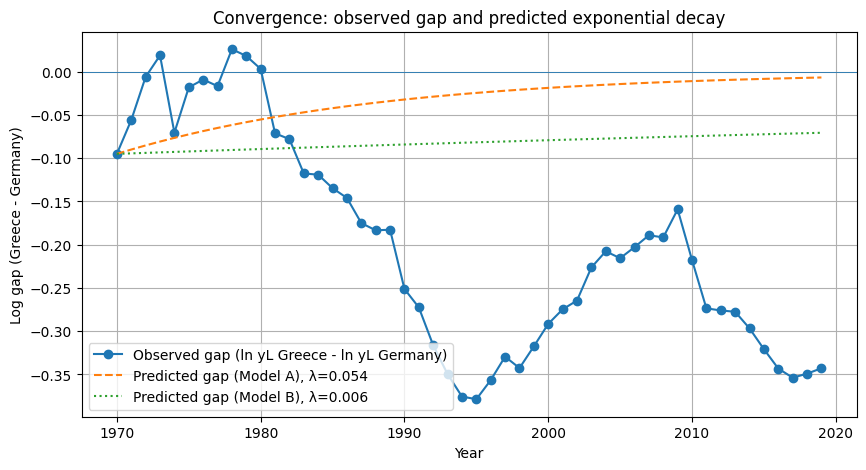


Summary table:
            Model    alpha     beta    gamma   lambda  half_life_years  half_life_calendar  t90_years
  MRW_no_patents 0.266673      NaN 0.000000 0.054172        12.795266                2032  42.504955
MRW_with_patents 0.135909 0.802528 0.003261 0.006056       114.456814                2134 380.217307


In [4]:
# Estimación de convergencia Grecia -> Alemania

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from math import log, ceil

# Preparamos las bases de datos a utilizar
USE_PREMERGED = False
COUNTRY_CODE = "GRC"
POLO_CODE    = "DEU"
START_YEAR   = 1970
END_YEAR     = 2019

# Parámetros de calibración
g_tech = 0.02      # Progreso tecnológico
delta_k = 0.05     # Depreciación del capital físico
delta_h = 0.03     # Depreciación del capital humano

# Preparamos la PWT
pwt = pwt[["country","countrycode","year","rgdpna","rnna","emp","hc","labsh","pop"]].copy()
pwt = pwt[(pwt["rgdpna"]>0) & (pwt["rnna"]>0) & (pwt["emp"]>0) & (pwt["hc"]>0)]

# Preparamos el proxy de patentes
if not USE_PREMERGED:
    try:
        #proxy_raw = pd.read_excel(PATENT_FILE, sheet_name=PATENT_SHEET, header=None)
        years = proxy_raw.iloc[9, 1:].tolist()
        countries = proxy_raw.iloc[10:, 0].tolist()
        data = proxy_raw.iloc[10:, 1:].reset_index(drop=True)
        data.columns = years
        data.insert(0, 'country', countries)
        data_long = data.melt(id_vars='country', var_name='year', value_name='patentes')
        data_long['year'] = pd.to_numeric(data_long['year'], errors='coerce')
    except Exception as e:
        # fallback: try to read sheet as long-format table
        data_long = pd.read_excel(PATENT_FILE)
        if not {'country','year','patentes'}.issubset(set(data_long.columns)):
            raise RuntimeError("Patent file not in expected format. Provide long format with columns ['country','year','patentes'] or correct PATENT_FILE/PATENT_SHEET.")
    bd = pd.merge(pwt, data_long, left_on=["country","year"], right_on=["country","year"], how="left")
else:
    bd = globals().get("bd_merged", None)
    if bd is None:
        raise RuntimeError("USE_PREMERGED=True but bd_merged not found. Load bd_merged or set USE_PREMERGED=False.")

# Armamos el índice de patentes por millón de personas y las transformaciones logarítmicas
bd['patentes'] = pd.to_numeric(bd['patentes'], errors='coerce').fillna(0)
bd['patpc_pm'] = bd['patentes'] / (bd['pop'] / 1e6)    # patentes por millón
bd['ln_patpc'] = np.log1p(bd['patpc_pm'])              # ln(1 + pat_per_millon)
bd['ln_patpc_lag1'] = bd.groupby('country')['ln_patpc'].shift(1)

# seleccionamos los años a considerar
bd = bd[(bd['year']>=START_YEAR) & (bd['year']<=END_YEAR)].copy()

# Preparamos las series de Grecia y Alemania
gr = bd[bd['countrycode']==COUNTRY_CODE].copy()
de = bd[bd['countrycode']==POLO_CODE].copy()

if gr.empty or de.empty:
    raise RuntimeError("No data for Greece or Germany in selected range. Check country codes and data coverage.")

# logs per trabajador
gr['ln_yL'] = np.log(gr['rgdpna'] / gr['emp'])
gr['ln_kL'] = np.log(gr['rnna'] / gr['emp'])
gr['ln_hc'] = np.log(gr['hc'])
gr['pop_g']  = np.log(gr['pop']).diff()

de['ln_yL'] = np.log(de['rgdpna'] / de['emp'])
de['ln_kL'] = np.log(de['rnna'] / de['emp'])
de['ln_hc'] = np.log(de['hc'])

gr = gr.reset_index(drop=True)
de = de.reset_index(drop=True)
n_bar = float(gr['pop_g'].mean(skipna=True))

# Regresiones

# Model A: MRW (K and HC)
X_A = sm.add_constant(gr[['ln_kL','ln_hc']])
y = gr['ln_yL']
mA = sm.OLS(y, X_A, missing='drop').fit(cov_type='HC1')

# Model B: MRW + patentes (lagged)
X_B = sm.add_constant(gr[['ln_kL','ln_hc','ln_patpc_lag1']])
mB = sm.OLS(y, X_B, missing='drop').fit(cov_type='HC1')

alpha_A = float(mA.params['ln_kL'])
alpha_B = float(mB.params['ln_kL'])
beta_B  = float(mB.params['ln_hc'])
gamma_B = float(mB.params.get('ln_patpc_lag1', 0.0))

# Computamos las velocidades y half-lives

lambda_A = (1.0 - alpha_A) * (n_bar + g_tech + delta_k)
lambda_B = (1.0 - alpha_B - beta_B - gamma_B) * (n_bar + g_tech + delta_k + delta_h)

t_half_A = np.log(2) / lambda_A if lambda_A>0 else np.nan
t_half_B = np.log(2) / lambda_B if lambda_B>0 else np.nan

t90_A = np.log(10) / lambda_A if lambda_A>0 else np.nan
t90_B = np.log(10) / lambda_B if lambda_B>0 else np.nan

last_year = int(gr['year'].max())
year_half_A = last_year + ceil(t_half_A) if np.isfinite(t_half_A) else None
year_half_B = last_year + ceil(t_half_B) if np.isfinite(t_half_B) else None

# Brecha observable
merge = pd.merge(gr[['year','ln_yL']], de[['year','ln_yL']], on='year', how='inner', suffixes=('_GRC','_DEU')).sort_values('year')
merge['gap'] = merge['ln_yL_GRC'] - merge['ln_yL_DEU']
merge = merge.reset_index(drop=True)

if len(merge)>0:
    t0 = merge['year'].iloc[0]
    years = merge['year'].values
    gap0 = merge['gap'].iloc[0]
    pred_gap_A = gap0 * np.exp(-lambda_A * (years - t0))
    pred_gap_B = gap0 * np.exp(-lambda_B * (years - t0))
else:
    pred_gap_A = pred_gap_B = np.array([])

# Imprimimos los resultados!!
print("\n=== MRW (no patents) ===")
print(mA.summary())
print("\n=== MRW + Patentes (lagged) ===")
print(mB.summary())

print("\n--- Convergence summary ---")
print(f"Greece average pop growth n: {n_bar:.4f}")
print(f"Model A (no patents): lambda={lambda_A:.4f}, half-life={t_half_A:.2f} yrs (≈ {year_half_A})")
print(f"Model B (with patents): lambda={lambda_B:.4f}, half-life={t_half_B:.2f} yrs (≈ {year_half_B})")

# Graficamos las trayectorias
# https://tenor.com/es-AR/view/homero-para-m%C3%A1s-placer-gif-21446698
plt.figure(figsize=(10,5))
plt.plot(merge['year'], merge['gap'], marker='o', label='Observed gap (ln yL Greece - ln yL Germany)')
if len(pred_gap_A)>0:
    plt.plot(years, pred_gap_A, linestyle='--', label=f'Predicted gap (Model A), λ={lambda_A:.3f}')
if len(pred_gap_B)>0:
    plt.plot(years, pred_gap_B, linestyle=':', label=f'Predicted gap (Model B), λ={lambda_B:.3f}')
plt.axhline(0, linewidth=0.6)
plt.xlabel('Year')
plt.ylabel('Log gap (Greece - Germany)')
plt.title('Convergence: observed gap and predicted exponential decay')
plt.legend()
plt.grid(True)
plt.show()

# Tablita de resumen de resultados
# https://tenor.com/es-AR/view/homero-para-m%C3%A1s-placer-gif-21446698
out = pd.DataFrame({
    'Model': ['MRW_no_patents','MRW_with_patents'],
    'alpha': [alpha_A, alpha_B],
    'beta': [np.nan, beta_B],
    'gamma': [0.0, gamma_B],
    'lambda': [lambda_A, lambda_B],
    'half_life_years': [t_half_A, t_half_B],
    'half_life_calendar': [year_half_A, year_half_B],
    't90_years': [t90_A, t90_B]
})
print("\nSummary table:\n", out.to_string(index=False))
